<a href="https://colab.research.google.com/github/MateoPeri/solar-predictor/blob/master/SolarPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import spatial
import pandas as pd
import glob
!pip install utm
import utm

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
import altair as alt
from scipy import spatial

plt.style.use('seaborn-poster')

  Created wheel for utm: filename=utm-0.5.0-cp36-none-any.whl size=5903 sha256=6809aa77858352efb3bb394bdacc9323239231f2494afb98e3e4be6aa3b36708
  Stored in directory: /root/.cache/pip/wheels/22/85/c2/314ffed39b8e02ca623e9b7d2ad7fcf3f8544a0e77c096be76
Successfully built utm


In [2]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/solar-predictor/master/data.zip
!unzip {PATH}data.zip

--2020-04-12 21:55:55--  https://raw.githubusercontent.com/MateoPeri/solar-predictor/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578244 (1.5M) [application/zip]
Saving to: ‘/content/data/data.zip’

data.zip            100%[===================>]   1.50M  --.-KB/s    in 0.1s    

2020-04-12 21:55:55 (10.5 MB/s) - ‘/content/data/data.zip’ saved [1578244/1578244]

Archive:  /content/data/data.zip
  inflating: data/AL31.csv           
  inflating: data/AL62.csv           
  inflating: data/CA12.csv           
  inflating: data/CA21.csv           
  inflating: data/CA52.csv           
  inflating: data/CA91.csv           
  inflating: data/CI32.csv           
  inflating: data/CI52.csv           
  inflating: data/CR32.csv           
  inflating: d

In [3]:
pattern = 'data/*.csv'
csv_files = glob.glob(pattern)

frames = []

for csv in csv_files:
  if csv == 'data/stations.csv':
    continue
  df = pd.read_csv(csv, parse_dates=True, sep=';', escapechar='\\', encoding='ISO-8859-1', decimal=',', thousands='.')
  frames.append(df)

df = pd.concat(frames, ignore_index=True)

df.head()

,ESTACION,MUNICIPIO,PARAJE,HORAS,FECHA,HSOL (h),RADMAX (w/m2),RADMED (w/m2),Unnamed: 8
0,MU31,Murcia,La Vereda,24.0,01/01/00,7.0,482.0,111.08,NaN
1,MU31,Murcia,La Vereda,24.0,02/01/00,7.0,485.0,111.88,NaN
2,MU31,Murcia,La Vereda,24.0,03/01/00,6.0,545.0,77.83,NaN
3,MU31,Murcia,La Vereda,24.0,04/01/00,6.0,630.0,82.21,NaN
4,MU31,Murcia,La Vereda,24.0,05/01/00,7.0,481.0,109.04,NaN


In [4]:
df.dtypes

ESTACION           object
MUNICIPIO          object
PARAJE             object
HORAS             float64
FECHA              object
HSOL  (h)         float64
RADMAX  (w/m2)    float64
RADMED  (w/m2)    float64
Unnamed: 8        float64
dtype: object

In [5]:
df.FECHA = pd.to_datetime(df.FECHA)
df = df.drop(['Unnamed: 8', 'HORAS'], axis=1)
df.rename(columns={'HSOL  (h)': 'HSUN', 'RADMAX  (w/m2)': 'RADMAX', 'RADMED  (w/m2)': 'RADAVG', 'ESTACION': 'STATION', 'MUNICIPIO': 'TOWN', 'PARAJE': 'PLACE', 'FECHA': 'DATE'}, inplace=True)

df.head()

,STATION,TOWN,PLACE,DATE,HSUN,RADMAX,RADAVG
0,MU31,Murcia,La Vereda,2000-01-01,7.0,482.0,111.08
1,MU31,Murcia,La Vereda,2000-02-01,7.0,485.0,111.88
2,MU31,Murcia,La Vereda,2000-03-01,6.0,545.0,77.83
3,MU31,Murcia,La Vereda,2000-04-01,6.0,630.0,82.21
4,MU31,Murcia,La Vereda,2000-05-01,7.0,481.0,109.04


## Merging

In [7]:
stations = pd.read_csv('data/stations.csv', sep=';')
stations['Utmy'], stations['Utmx'] = utm.to_latlon(stations['Utmx'], stations['Utmy'], zone_number=30, zone_letter="S")
stations.rename(columns={'Estación': 'STATION', 'Utmy': 'LAT', 'Utmx': 'LON'}, inplace=True)
stations.head()

,STATION,LAT,LON
0,AL31,37.734317,-1.511796
1,AL62,37.562186,-1.400979
2,CA21,37.833234,-1.121357
3,CA52,37.678868,-1.069549
4,CA91,37.700815,-1.236519


In [8]:
result = pd.merge(df, stations, on='STATION')
result.head()

,STATION,TOWN,PLACE,DATE,HSUN,RADMAX,RADAVG,LAT,LON
0,MU31,Murcia,La Vereda,2000-01-01,7.0,482.0,111.08,37.900056,-1.266895
1,MU31,Murcia,La Vereda,2000-02-01,7.0,485.0,111.88,37.900056,-1.266895
2,MU31,Murcia,La Vereda,2000-03-01,6.0,545.0,77.83,37.900056,-1.266895
3,MU31,Murcia,La Vereda,2000-04-01,6.0,630.0,82.21,37.900056,-1.266895
4,MU31,Murcia,La Vereda,2000-05-01,7.0,481.0,109.04,37.900056,-1.266895


## Missings

In [0]:
coordinates = result[['LAT', 'LON']]
coordinates.drop_duplicates()
location = [37.9922, 1.1307]
tree = spatial.cKDTree(coordinates)
dist, ix = tree.query(location, 1)

In [10]:
LAT = result['LAT']==coordinates.iloc[ix,0]
LON = result['LON']==coordinates.iloc[ix,1]

result = result[LAT]
result = result[LON]

result = result.drop(columns = ['LAT', 'LON'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [11]:
print(result.loc[result.HSUN > 8].shape, result.shape)

(4542, 7) (6854, 7)


In [0]:
result = result.loc[result.HSUN > 8] # minimum hours of sun

In [13]:
# Find columns with NaN values
print(result.isnull().sum())
result.loc[:, result.isna().any()].head()

STATION    0
TOWN       0
PLACE      0
DATE       0
HSUN       0
RADMAX     0
RADAVG     0
dtype: int64


""
6941
6942
6943
6944
6946


In [14]:
miss_cols = result.columns[result.isnull().any()]
result["miss"] = 0
for col in miss_cols:
  result[col].isnull()["miss"] = 1
  result[col] = result[col].fillna(method='bfill')

result[result.isna().any(axis=1)].head()
result.isnull().sum()

STATION    0
TOWN       0
PLACE      0
DATE       0
HSUN       0
RADMAX     0
RADAVG     0
miss       0
dtype: int64

In [15]:
result.RADAVG.describe()

count    4542.000000
mean      256.879958
std        62.671829
min        68.090000
25%       206.190000
50%       264.210000
75%       311.580000
max       369.420000
Name: RADAVG, dtype: float64

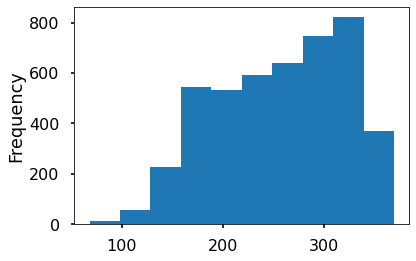

In [16]:
result.RADAVG.plot(kind='hist')
plt.show()

# Training

## Initial Model

In [0]:
data = result[['DATE', 'RADAVG']].copy()
data.columns = ['ds', 'y']

In [0]:
def generate_model(dff):
  fecha = '2011-01-01'

  df_prediccion = dff.loc[dff.ds > fecha].copy()

  rad_max = df_prediccion['y'].max()
  rad_min = df_prediccion['y'].min()

  df_prediccion['cap'] = rad_max
  df_prediccion['floor'] = rad_min


  modelo_futuro = Prophet(growth= 'logistic', seasonality_mode = 'additive', changepoint_prior_scale =0.05, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
            ).add_seasonality(name='daily',period=1,fourier_order=3, prior_scale = 0.2
            ).add_seasonality(name='weekly',period=7,fourier_order=3, prior_scale = 0.2
            ).add_seasonality(name='monthly',period=30.50,fourier_order=3, prior_scale = 0.2
            ).add_seasonality(name='quaterly',period=365.25/4,fourier_order=3, prior_scale = 0.1
            ).add_seasonality(name='yearly',period=365.25,fourier_order=4, prior_scale = 0.2)
  return modelo_futuro, df_prediccion

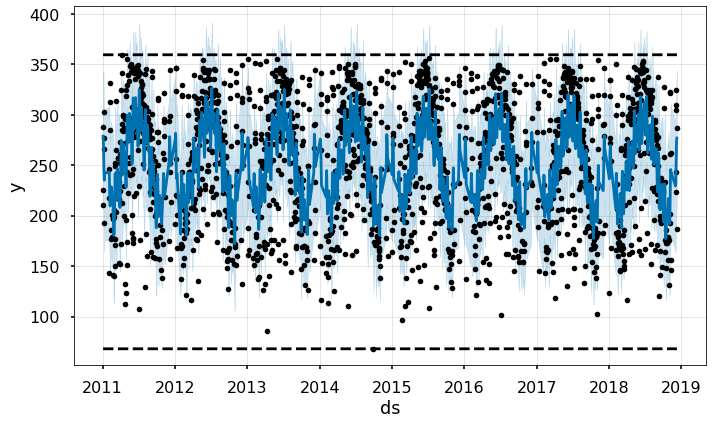

In [19]:
model, df_pred = generate_model(data)
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [20]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 35.29%


## Eliminate Anomalies

In [0]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [22]:
pred = detect_anomalies(forecast)
print(len(pred))
pred = pred[pred.anomaly==0]
print('Accuracy: {:.2f}%'.format(r2_score(pred.fact, pred.yhat)*100))

1938
Accuracy: 56.85%


## Train with clean model

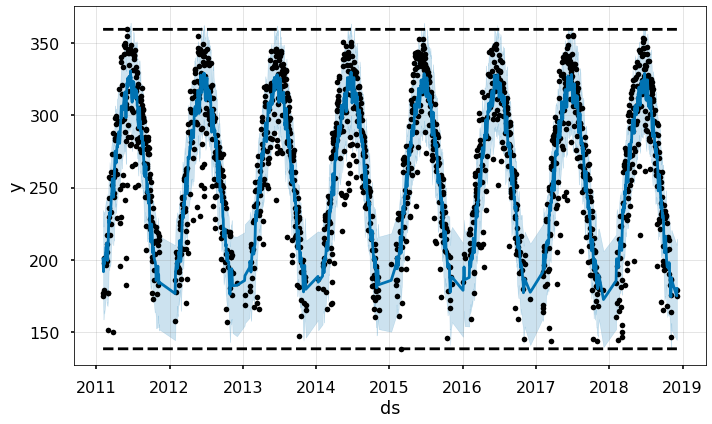

In [23]:
clean_df = pred[['ds', 'fact']]
clean_df.columns = ['ds', 'y']
clean_model, clean_df_pred = generate_model(clean_df.copy())
clean_model.fit(clean_df_pred)
clean_forecast = clean_model.predict(clean_df_pred)
fig2 = clean_model.plot(clean_forecast)

In [24]:
clean_forecast['fact'] = clean_df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(clean_forecast.fact, clean_forecast.yhat)*100))

Accuracy: 74.61%


## Predict future

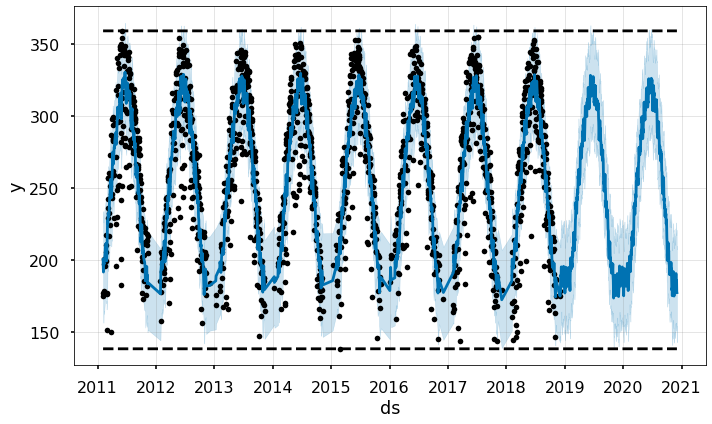

In [25]:
# 2 more years from end of data
future = clean_model.make_future_dataframe(periods=730, freq='d')

rad_max = clean_df['y'].max()
rad_min = clean_df['y'].min()
future['cap'] = rad_max
future['floor'] = rad_min
future_forecast = clean_model.predict(future)
fig = clean_model.plot(future_forecast)

In [0]:
df_2020 = future_forecast[future_forecast.ds >= pd.to_datetime('01-01-2020')]
df_2020 = df_2020[['ds', 'yhat']]

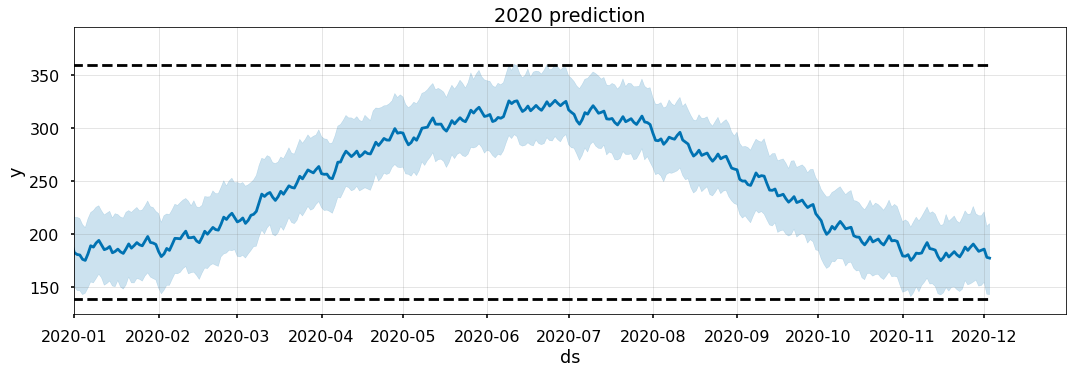

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
#ax.scatter(pd.to_datetime(datos_test.index), datos_test['y'], color='r')
fig = clean_model.plot(future_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2020'), upper=pd.to_datetime('12-31-2020'))
ax.set_ylim(rad_min*0.9, rad_max*1.1)
plot = plt.title('2020 prediction')

In [28]:
global_rad = df_2020.mean()[0]
global_rad /= 1000 # Wh/m2 -> KWh/m2
print ('{:.4f} KWh/m2'.format(global_rad))

0.2485 KWh/m2


## Sun Hours Prediction

In [0]:
hour_data = result[['DATE', 'HSUN']]
hour_data.columns = ['ds', 'y']

# Generate Model
hour_model, hour_df = generate_model(hour_data)
hour_model.fit(hour_df)
hour_forecast = hour_model.predict(hour_df)
hour_forecast['fact'] = hour_df['y'].reset_index(drop = True)

# Anomalies
hour_pred = detect_anomalies(hour_forecast)
hour_pred = hour_pred[hour_pred.anomaly==0]

# Generate model again
hour_df = hour_pred[['ds', 'fact']]
hour_df.columns = ['ds', 'y']
hour_model, hour_pred = generate_model(hour_df)
hour_model.fit(hour_pred)
hour_forecast = hour_model.predict(hour_pred)


# 2 more years from end of data
hour_future = hour_model.make_future_dataframe(periods=730, freq='d')

hours_max = hour_df['y'].max()
hours_min = hour_df['y'].min()
hour_future['cap'] = hours_max
hour_future['floor'] = hours_min
hour_forecast = hour_model.predict(hour_future)

hours_2020 = hour_forecast[hour_forecast.ds >= pd.to_datetime('01-01-2020')]
hours_2020 = hours_2020[['ds', 'yhat']]

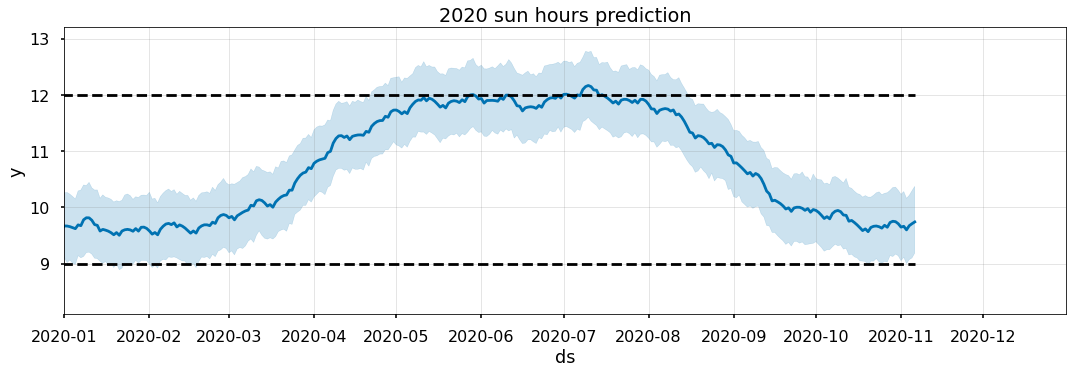

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
#ax.scatter(pd.to_datetime(datos_test.index), datos_test['y'], color='r')
fig = hour_model.plot(hour_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2020'), upper=pd.to_datetime('12-31-2020'))
ax.set_ylim(hours_min*0.9, hours_max*1.1)
plot = plt.title('2020 sun hours prediction')

# Power Generation

In [31]:
Pmax = 300 # Maximum Power (Wp)
Eff = 0.8 # 80% standard efficiency

HSP = df_2020[['yhat']]*24/1000

e_df = HSP * Pmax * Eff
e_df = e_df.join(df_2020[['ds']])
e_df['yhat'] /= 1000 # Wh -> KWh
e_df.columns = ['Production (KWh)', 'Date']
e_df.reset_index(drop=True, inplace=True)
e_df.set_index('Date', inplace=True)
e_df.head()

,Production (KWh)
Date,
2020-01-01,1.051759
2020-01-02,1.042059
2020-01-03,1.039254
2020-01-04,1.015907
2020-01-05,1.009799


## Export

In [0]:
# Power prediction for 2020
e_df.to_csv('power.csv')

In [0]:
# Historical data
hist = result[['STATION', 'TOWN', 'PLACE', 'DATE', 'HSUN', 'RADMAX', 'RADAVG']]
hist.reset_index(drop=True, inplace=True)
hist.set_index('DATE', inplace=True)
hist.to_csv('hist.csv')